<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Load" data-toc-modified-id="Load-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load</a></span></li><li><span><a href="#Using-XGBOOST" data-toc-modified-id="Using-XGBOOST-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Using XGBOOST</a></span></li><li><span><a href="#Plot-Results" data-toc-modified-id="Plot-Results-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Plot Results</a></span><ul class="toc-item"><li><span><a href="#Load-results" data-toc-modified-id="Load-results-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Load results</a></span><ul class="toc-item"><li><span><a href="#Show-results" data-toc-modified-id="Show-results-3.1.1"><span class="toc-item-num">3.1.1&nbsp;&nbsp;</span>Show results</a></span></li><li><span><a href="#Identify-which-AUC-curve-is-the-closest-to-the-mean-one-(e.g.-compare-AUCs-to-mean-AUC)" data-toc-modified-id="Identify-which-AUC-curve-is-the-closest-to-the-mean-one-(e.g.-compare-AUCs-to-mean-AUC)-3.1.2"><span class="toc-item-num">3.1.2&nbsp;&nbsp;</span>Identify which AUC curve is the closest to the mean one (e.g. compare AUCs to mean AUC)</a></span><ul class="toc-item"><li><span><a href="#FPR-vs-FNR-curves" data-toc-modified-id="FPR-vs-FNR-curves-3.1.2.1"><span class="toc-item-num">3.1.2.1&nbsp;&nbsp;</span>FPR vs FNR curves</a></span></li></ul></li></ul></li></ul></li></ul></div>

This version includes some edits on the data (we go and fetch additional data) in order to test the classification or the post processing. 

# Load

In [81]:
# coding: utf-8



import os
import numpy as np
import pandas as pd
import csv   
import cv2 as cv

from sklearn import preprocessing
from scipy.stats import gaussian_kde
from sklearn import metrics

import matplotlib.pylab as plt
import matplotlib.pyplot as mpplt
import matplotlib.image as mpimg
cmap = plt.cm.rainbow
import matplotlib
norm = matplotlib.colors.Normalize(vmin=0., vmax=1.)

from helpers import *
from sklearn import metrics


In [10]:
# # Load classification data


path_to_load_data = os.path.join('../../../data/')

X = pd.read_csv(os.path.join(path_to_load_data,'spotData_filtered.csv'), index_col=0)

In [11]:
X.shape

(1952, 20)

In [12]:
x=X['Annotation']

x=x.value_counts()

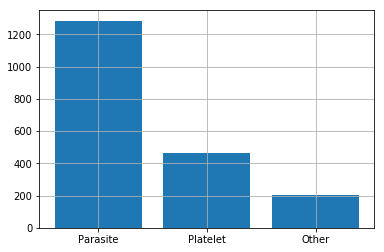

In [13]:
mpplt.bar(np.arange(x.shape[0]),x)
plt.xticks(np.arange(x.shape[0]), x.index);
plt.grid(True)

In [14]:
idx_spotWithSaturatedPixels = X['numSaturatedPixels']>0
X = X[~idx_spotWithSaturatedPixels]


print('X',X.shape)

X (1905, 20)


In [15]:
X["R/B"] = X["R"] / X["B"]
X["G/B"] = X["G"] / X["B"]

In [16]:
# ### Get features 
features = ['R','G','B','R_max','G_max','B_max', 'lap_total','numPixels','numSaturatedPixels', 'R/B', 'G/B','size'] 
# features=['R/B','G/B']
X_ = X[features]

print("X_: ",X_.shape)

X_:  (1905, 12)


In [17]:
# ### Get labels
labels = ['Annotation'] 

# get labels
y = X[labels]

y = np.asarray(y).flatten()

# convert labels to 0 / 1
for i in range(y.shape[0]):
    if y[i] == 'Parasite':
        y[i]=1
    elif y[i] == 'Platelet':
        y[i]=0
    elif y[i] == 'Nothing':
        y[i]=2
    else:
        y[i]=3
    
# y[y=='Parasite'] = 1
# y[y=='Platelet'] = 0
# y[y=='Nothing'] = 2

print("y: ", y.shape)
print(np.unique(y, return_counts=True))

y:  (1905,)
(array([0, 1, 3], dtype=object), array([ 456, 1254,  195]))


(0, 1.5)

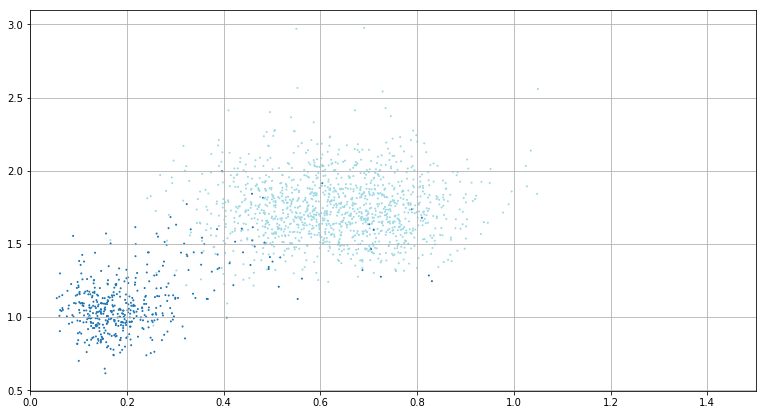

In [18]:
indx_=np.where(np.logical_or(y==0,y==1))[0]

plt.figure(figsize=(13,7))
scatter=plt.scatter(X_['R/B'].values[indx_],X_['G/B'].values[indx_],s=1,c=y[indx_],cmap='tab20')
plt.grid(True)
plt.xlim([0,1.5])

(0, 1.5)

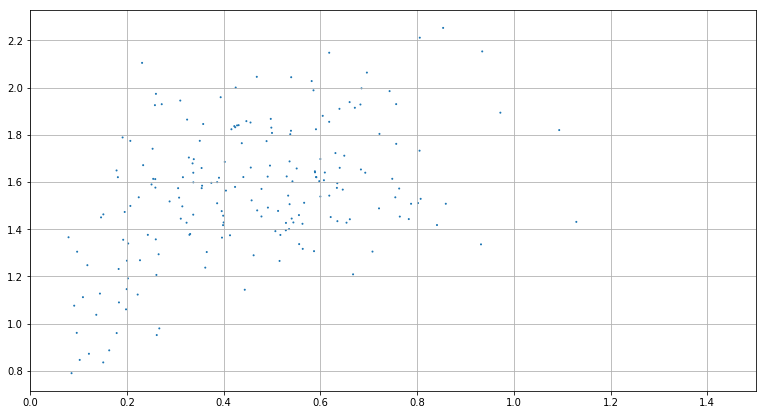

In [19]:
indx_=np.where(np.logical_or(y==2,y==3))[0]
plt.figure(figsize=(13,7))
scatter=plt.scatter(X_['R/B'].values[indx_],X_['G/B'].values[indx_],s=1,c=y[indx_],cmap='tab20')
plt.grid(True)
plt.xlim([0,1.5])

(0, 1.5)

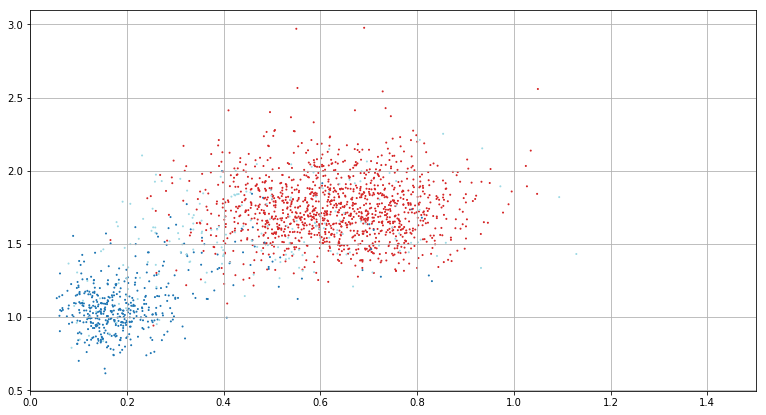

In [20]:
plt.figure(figsize=(13,7))
scatter=plt.scatter(X_['R/B'],X_['G/B'],s=1,c=y,cmap='tab20')
plt.grid(True)
plt.xlim([0,1.5])

# Using XGBOOST

Create CV folds

In [30]:
np.random.seed(0)
n_folds = 20

# List patients
slides_PF = ['1128-p-63', '1128-p-64', '1128-p-66', '1128-p-67', '1128-p-74', '1128-p-75', '1128-p-76b', '1128-p-79']
slides_WB = ['1128-w-16', '1128-w-17', '1128-w-18', '1128-w-19', '1128-w-20', '1128-w-31', '1128-w-32', '1128-w-41', '1128-w-42', '1128-w-43']
print('slides_PF',len(slides_PF))
print('slides_WB',len(slides_WB))

folds = {}
for i in range(n_folds): 
    # Pick 3 PF slides
    fold_slides_PF = list(np.random.choice(slides_PF, size=3, replace=False))
    # Pick 3 WB slides
    fold_slides_WB = list(np.random.choice(slides_WB, size=3, replace=False))
    folds['fold_'+str(i)] = fold_slides_PF + fold_slides_WB
    
# Get idx corresponding to each fold
fold_idx = {}
# Iterate over folds
for fold, fold_folders in folds.items():
    # Get test idx 
    test_idx = X_with_helpers_with_overlap['foldername'].isin(fold_folders)
    fold_idx[fold] = test_idx



slides_PF 8
slides_WB 10


NameError: name 'X_with_helpers_with_overlap' is not defined

In [22]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
np.random.seed(0)

In [23]:
params = { 
    'learning_rate':0.10, #0.10 
    'n_estimators': 233, #233, 
    'max_depth':6, # 6 
    'min_child_weight': 10, #10 
    'gamma': 1., # 1. 
    'subsample':1., # 1. 
    'colsample_bytree':1., #1. 
    'objective':'binary:logistic',
    'nthread':-1,
    'scale_pos_weight':1., #1. 
    'seed':2, # 2
    'reg_lambda':30., # 30. 
    'reg_alpha':0., # 0. 
}



In [77]:
test_size=10/100

test_idx_=np.random.choice(np.arange(0,X_.shape[0],1),size=int(X_.shape[0]*test_size),replace=False)

test_idx=X_.index.isin(test_idx_)

In [79]:
# Train classifier to predict parasites vs rest of the world
y[y == 2] = 0
y[y == 3] = 0

In [102]:
from sklearn.utils.multiclass import type_of_target

from sklearn.preprocessing import LabelEncoder

In [103]:
fnrs_global,fprs_global,thresholds_global,fold_global,auc_global,fpr_value_global,fnr_value_global = [],[],[],[],[],[],[]

#we do not do cross validation for now

foldername_k_global,filename_k_global,spot_idx_k_global,overlap_k_global = [],[],[],[]

# Get train data
X_train = X_[~test_idx]
X_train = np.asarray(X_train)
y_train = y[~test_idx]
# Get test data
X_test = X_[test_idx]
X_test = np.asarray(X_test)
y_test = y[test_idx]

#transform into appropriate format
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.fit_transform(y_test)

# Normalize train data. Note: Do not normalize overlap! 
X_train_1 = X_train[:,:-1]
X_train_2 = X_train[:,-1:]
mean_1 = np.mean(X_train_1, axis=0,keepdims=True)
std_1 = np.std(X_train_1, axis=0,keepdims=True)
X_train_1 = (X_train_1 - mean_1) / (std_1 + 1e-8)
X_train = np.concatenate([X_train_1,X_train_2],axis=1)
# Normalize test data. Note: We use train mean+variance. Note: Do not normalize overlap! 
X_test_1 = X_test[:,:-1]
X_test_2 = X_test[:,-1:]
X_test_1 = (X_test_1 - mean_1) / (std_1 + 1e-8)
X_test = np.concatenate([X_test_1,X_test_2],axis=1)

# Shuffle train data
p_train = np.random.permutation(len(y_train))
X_train = X_train[p_train]
y_train = y_train[p_train]
# Shuffle test data
p_test = np.random.permutation(len(y_test))
X_test = X_test[p_test]
y_test = y_test[p_test]
print('y_train',np.unique(y_train,return_counts=True))
print('y_test',np.unique(y_test,return_counts=True))

########################################
# TRAINING
########################################
# Create XGBClassifier
xgb = XGBClassifier(**params)
# Train XGBClassifier
train_fit = xgb.fit(X_train, y_train)

#Deploy XGBClassifier on training set
dtrain_predprob = xgb.predict_proba(X_train)[:,1]
print('Train AUC: ', metrics.roc_auc_score(y_train, dtrain_predprob) )
#Deploy XGBClassifier on test set
dtest_predprob = xgb.predict_proba(X_test)[:,1]
auc = metrics.roc_auc_score(y_test, dtest_predprob)
print('Test AUC: ', auc)

# Find decision threshold to match FNR just under 10%
target_fnr_value = 0.1
fprs, tprs, thresholds = metrics.roc_curve(y_test, dtest_predprob)
fnrs = 1. - tprs
idx_my_decision_threshold = np.where( fnrs < target_fnr_value )[0][0]
decision_threshold = thresholds[idx_my_decision_threshold]
fpr_value_ = fprs[idx_my_decision_threshold]
fnr_value_ = fnrs[idx_my_decision_threshold]
dtest_predprob_binarized = 1.*(dtest_predprob>=decision_threshold)
tn_, fp_, fn_, tp_ = metrics.confusion_matrix(y_test, dtest_predprob_binarized).ravel()
print('nb of fp_: ',fp_)
print('nb of fn_: ',fn_)
print('fpr_value_: ',fpr_value_)
print('fnr_value_: ',fnr_value_)
# print results
print('The FPR corresponding to a FNR of '+str(fnr_value_)+' is: %.6g' % fpr_value_) 

# Book keeping
fnrs_global.append(fnrs)
fprs_global.append(fprs)
thresholds_global.append(thresholds)
fold_global.append(fold)
auc_global.append(auc)
fpr_value_global.append(fpr_value_)
fnr_value_global.append(fnr_value_)

y_train (array([0, 1]), array([ 583, 1132]))
y_test (array([0, 1]), array([ 68, 122]))
Train AUC:  0.9695729715314354
Test AUC:  0.9575096432015429
nb of fp_:  9
nb of fn_:  11
fpr_value_:  0.1323529411764706
fnr_value_:  0.0901639344262295
The FPR corresponding to a FNR of 0.0901639344262295 is: 0.132353


In [ ]:
########################################
# Error analysis: plot mispredicted (FP, FN) for error analysis
########################################

# Get FP spots
idx_FP = np.logical_and(dtest_predprob_binarized==1,y_test==0)
X_test_FP = X_test[idx_FP]
list_idx_FP = np.where(idx_FP)
list_idx_FP = list(list_idx_FP[0])
print('list_idx_FP',len(list_idx_FP))
# Get FN spots
idx_FN = np.logical_and(dtest_predprob_binarized==0,y_test==1)
X_test_FN = X_test[idx_FN]
list_idx_FN = np.where(idx_FN)
list_idx_FN = list(list_idx_FN[0])
print('list_idx_FN',len(list_idx_FN))

X_test_ = X_with_helpers_with_overlap[test_idx]
X_test_ = X_test_.reset_index(drop=True)
X_test_ = X_test_.reindex(p_test)
X_test_ = X_test_.reset_index(drop=True)
# FP
X_test_FP_ = X_test_[idx_FP]
X_test_FP_ = X_test_FP_.reset_index(drop=True)
# FN
X_test_FN_ = X_test_[idx_FN]
X_test_FN_ = X_test_FN_.reset_index(drop=True)

n_FP = X_test_FP.shape[0]
n_FP_ = min(n_FP,30)
prev_filename_k = ''
prev_foldername_k = ''
# Iterate over FPs
for k in range(n_FP_):
    # Get meta features
    X_test_FP_k = X_test_FP_.iloc[k]
    foldername_k = X_test_FP_k['foldername']
    filename_k = X_test_FP_k['filename']
    spot_idx_k = X_test_FP_k['spot_idx']
    overlap_k = X_test_FP_k['overlap']

    if (foldername_k!=prev_foldername_k) or (filename_k!=prev_filename_k):
        # Load corresponding img
        path_to_patient = os.path.join('..','data',foldername_k)
        path_to_fluo_imgs = os.path.join( path_to_patient,'raw_data','fluorescent' )
        path_to_fluo_img = os.path.join(path_to_fluo_imgs,filename_k)
        if not os.path.isfile(path_to_fluo_img):
            raise ValueError('Image does not exist',foldername_k,filename_k,path_to_fluo_img)
        img_fluo_raw = mpimg.imread(path_to_fluo_img)
        # Rescale image to [0,1]
        img_fluo_raw = img_fluo_raw/255.
        # Crop image 
        x_low,x_high,y_low,y_high = crop_box
        img_fluo_raw = img_fluo_raw[x_low:x_high,y_low:y_high,:]
        # Morphological top-hat transform filtering on each channel of the fluo image
        # We compute the morphological opening of each channel, and then subtracts the result from the original channel
        tophat_filter = np.zeros_like(img_fluo_raw)
        for c in range(img_fluo_raw.shape[-1]):
            tophat_filter[:,:,c] = cv.morphologyEx(img_fluo_raw[:,:,c], cv.MORPH_OPEN, kernel)
        img_fluo = img_fluo_raw - tophat_filter

    # Get pixels of spot
    points = np.asarray( eval(spot_idx_k) )
    ys = points[:,0]; xs = points[:,1]

    # Zoom on the image around spot
    crop_margin = 25
    x_min = np.amin(xs); x_max = np.amax(xs); y_min = np.amin(ys); y_max = np.amax(ys);
    # Get zoomed raw image
    img_fluo_raw_cropped = img_fluo_raw[ max(x_min-crop_margin,0):x_max+crop_margin, max(y_min-crop_margin,0):y_max+crop_margin, :]
    # Get zoomed fluo image
    img_fluo_cropped = img_fluo[ max(x_min-crop_margin,0):x_max+crop_margin, max(y_min-crop_margin,0):y_max+crop_margin, :]

    # Save FP examples to disk
    path_to_dump_FP_viz = os.path.join(".","crossval_results_v3","FP_viz",fold)
    if not os.path.exists(path_to_dump_FP_viz): 
        os.makedirs(path_to_dump_FP_viz)
    # Save raw image 
    plt.close('all')
    fig, ax = plt.subplots(1, 1, figsize=(15,15), sharex=True, sharey=True)
    ax.imshow(img_fluo_raw, interpolation='nearest')
    margin = 1
    c = plt.Rectangle((y_min - margin, x_min - margin), y_max-y_min + 2*margin, x_max-x_min + 2*margin,color=[1.,0,0], lw=1.0, fill=False)
    ax.add_artist(c)
    plt.imshow(img_fluo_raw, alpha=0.6)
    plt.savefig( os.path.join(path_to_dump_FP_viz, fold+'_'+foldername_k+filename_k[:-4]+'_'+str(k)+'_box_raw.png' ))
    # Save zoomed raw image
    plt.close('all')
    fig, ax = plt.subplots(1, 1, figsize=(10,10), sharex=True, sharey=True)
    ax.imshow(img_fluo_raw_cropped, interpolation='nearest')
    margin = 1
    c = plt.Rectangle((crop_margin - margin, crop_margin - margin), y_max-y_min + 2*margin, x_max-x_min + 2*margin,color=[0.5,0,0], lw=1.0, fill=False)
    ax.add_artist(c)
    plt.imshow(img_fluo_raw_cropped, alpha=0.6)
    plt.savefig( os.path.join(path_to_dump_FP_viz, fold+'_'+foldername_k+filename_k[:-4]+'_'+str(k)+'_cropbox_raw.png' ))
    # Save zoomed fluo image
    plt.close('all')
    fig, ax = plt.subplots(1, 1, figsize=(10,10), sharex=True, sharey=True)
    ax.imshow(img_fluo_cropped, interpolation='nearest')
    margin = 1
    c = plt.Rectangle((crop_margin - margin, crop_margin - margin), y_max-y_min + 2*margin, x_max-x_min + 2*margin,color=[0.5,0,0], lw=1.0, fill=False)
    ax.add_artist(c)
    plt.imshow(img_fluo_cropped, alpha=0.6)
    plt.savefig( os.path.join(path_to_dump_FP_viz, fold+'_'+foldername_k+filename_k[:-4]+'_'+str(k)+'_cropbox_fluo.png' ))

    # We save the 4 images. We also save the meta data to find the image again
    foldername_k_global.append(foldername_k)
    filename_k_global.append(filename_k)
    spot_idx_k_global.append(spot_idx_k)
    overlap_k_global.append(overlap_k)

# Save foldername_k_global, foldername_k_global, spot_idx_k_global, overlap_k_global to disk
foldername_k_global = np.reshape(foldername_k_global, [-1,1])
filename_k_global = np.reshape(filename_k_global, [-1,1])
spot_idx_k_global = np.reshape(spot_idx_k_global, [-1,1])
overlap_k_global = np.reshape(overlap_k_global, [-1,1])

# Book keeping
if not os.path.exists(os.path.join(path_to_dump_FP_viz, str(fold))): 
    os.makedirs( os.path.join(path_to_dump_FP_viz, str(fold) ) )
# foldername_k_global
with open( os.path.join(path_to_dump_FP_viz, str(fold),"FP_foldername_k_global.csv"), "wb") as f:
    writer = csv.writer(f)
    writer.writerows(foldername_k_global)
# filename_k_global
with open( os.path.join(path_to_dump_FP_viz, str(fold),"FP_filename_k_global.csv"), "wb") as f:
    writer = csv.writer(f)
    writer.writerows(filename_k_global)
# spot_idx_k_global
with open( os.path.join(path_to_dump_FP_viz, str(fold),"FP_spot_idx_k_global.csv"), "wb") as f:
    writer = csv.writer(f)
    writer.writerows(spot_idx_k_global)
# overlap_k_global
with open( os.path.join(path_to_dump_FP_viz, str(fold),"FP_overlap_k_global.csv"), "wb") as f:
    writer = csv.writer(f)
    writer.writerows(overlap_k_global)

In [ ]:
# Save results to csv
print( len(fold_global))
print(len(auc_global))
print(len(fpr_value_global))
print(len(fnr_value_global))

fold_global = np.reshape(fold_global, [-1,1])
auc_global = np.reshape(auc_global, [-1,1])
fpr_value_global = np.reshape(fpr_value_global, [-1,1])
fnr_value_global = np.reshape(fnr_value_global, [-1,1])
print(fold_global.shape)
print(auc_global.shape)
print(fpr_value_global.shape)
print(fnr_value_global.shape)

with open( os.path.join(".","crossval_results_v3","fnrs_global.csv") , "wb") as f:
    writer = csv.writer(f)
    writer.writerows(fnrs_global)

with open( os.path.join(".","crossval_results_v3","fprs_global.csv") , "wb") as f:
    writer = csv.writer(f)
    writer.writerows(fprs_global)

with open( os.path.join(".","crossval_results_v3","thresholds_global.csv") , "wb") as f:
    writer = csv.writer(f)
    writer.writerows(thresholds_global)

with open( os.path.join(".","crossval_results_v3","fold_global.csv") , "wb") as f:
    writer = csv.writer(f)
    writer.writerows(fold_global)

with open( os.path.join(".","crossval_results_v3","auc_global.csv") , "wb") as f:
    writer = csv.writer(f)
    writer.writerows(auc_global)

with open( os.path.join(".","crossval_results_v3","fpr_value_global.csv") , "wb") as f:
    writer = csv.writer(f)
    writer.writerows(fpr_value_global)

with open( os.path.join(".","crossval_results_v3","fnr_value_global.csv") , "wb") as f:
    writer = csv.writer(f)
    writer.writerows(fnr_value_global)



# Plot Results

## Load results

In [ ]:
# Load results_v2 from csv

with open( os.path.join(".","crossval_results_v3","fnrs_global.csv")  , 'rb' ) as fp:
    reader = csv.reader(fp, delimiter=',', quotechar='"')
    fnrs_global = [row for row in reader]

with open( os.path.join(".","crossval_results_v3","fprs_global.csv")  , 'rb' ) as fp:
    reader = csv.reader(fp, delimiter=',', quotechar='"')
    fprs_global = [row for row in reader]

with open( os.path.join(".","crossval_results_v3","thresholds_global.csv")  , 'rb' ) as fp:
    reader = csv.reader(fp, delimiter=',', quotechar='"')
    thresholds_global = [row for row in reader]
    
with open( os.path.join(".","crossval_results_v3","fold_global.csv")  , 'rb' ) as fp:
    reader = csv.reader(fp, delimiter=',', quotechar='"')
    fold_global = [row for row in reader]

with open( os.path.join(".","crossval_results_v3","auc_global.csv")  , 'rb' ) as fp:
    reader = csv.reader(fp, delimiter=',', quotechar='"')
    auc_global = [row for row in reader]

with open( os.path.join(".","crossval_results_v3","fpr_value_global.csv")  , 'rb' ) as fp:
    reader = csv.reader(fp, delimiter=',', quotechar='"')
    fpr_value_global = [row for row in reader]

with open( os.path.join(".","crossval_results_v3","fnr_value_global.csv")  , 'rb' ) as fp:
    reader = csv.reader(fp, delimiter=',', quotechar='"')
    fnr_value_global = [row for row in reader]

    
fnrs_global = map( lambda x : map(eval,x), fnrs_global)
fprs_global = map( lambda x : map(eval,x), fprs_global)
thresholds_global = map( lambda x : map(eval,x), thresholds_global)

fold_global = map( lambda x : x[0], fold_global)
auc_global = map( lambda x : eval(x[0]), auc_global)
fpr_value_global = map( lambda x : eval(x[0]), fpr_value_global)
fnr_value_global = map( lambda x : eval(x[0]), fnr_value_global)

print(len(fnrs_global))
print(len(fprs_global))
print(len(thresholds_global))
print(len(fold_global))
print(len(auc_global))
print(len(fpr_value_global))
print(len(fnr_value_global))




### Show results

In [ ]:
# AUC
auc_mean = np.mean(auc_global)
auc_std = np.std(auc_global)
print('auc_mean: ',auc_mean)
print('auc_std: ',auc_std)

In [ ]:
# FPR
fpr_mean = np.mean(fpr_value_global)
fpr_std = np.std(fpr_value_global)
print('fpr_mean: ',fpr_mean)
print('fpr_std: ',fpr_std)

### Identify which AUC curve is the closest to the mean one (e.g. compare AUCs to mean AUC)

In [ ]:
auc_global_mean = np.mean(auc_global)
temp = np.abs(auc_global - auc_global_mean)
curve_closest_to_mean = np.argmin(temp)
curve_closest_to_mean
# curve_closest_to_mean = 3

#### FPR vs FNR curves

In [ ]:
n_folds = len(fnrs_global)
plt.figure( figsize=(15,10) )

# Iterate over the folds, except the mean curve
for i in range(n_folds):
    
    if i==curve_closest_to_mean:
        # we plot the 'mean' curve at the end
        continue

    fnrs = fnrs_global[i]
    fprs = fprs_global[i]
    thresholds = thresholds_global[i]
    fold = fold_global[i]
    assert len(fnrs) == len(fprs)
    assert len(fnrs) == len(thresholds)
    
    # Plot FPR vs FNR on test data
    lw = 1
    plt.plot(fnrs, fprs, color='gray',lw=lw, alpha=0.8)

# Plot the mean curve
i=curve_closest_to_mean
fnrs = fnrs_global[i]
fprs = fprs_global[i]
thresholds = thresholds_global[i]
fold = fold_global[i]
assert len(fnrs) == len(fprs)
assert len(fnrs) == len(thresholds)
plt.plot(fnrs, fprs, color='darkorange',lw=3)

plt.axvline(0.1, c='gray', ls='--')
plt.xlabel('FNR'); plt.ylabel('FPR'); plt.legend(loc="lower right");
plt.yscale('log'); plt.xscale('log'); plt.xlim([0.00001,1.]); plt.ylim([0.0000001,1.]);
plt.title('FPR vs FNR')
plt.show()
    
    



In [ ]:
n_folds = len(fnrs_global)
plt.figure( figsize=(15,10) )

# Iterate over the folds
for i in range(n_folds):
    
    if i==curve_closest_to_mean:
        # we plot the 'mean' curve at the end
        continue

    fnrs = fnrs_global[i]
    fprs = fprs_global[i]
    thresholds = thresholds_global[i]
    fold = fold_global[i]
    assert len(fnrs) == len(fprs)
    assert len(fnrs) == len(thresholds)
    
    ### 
    # Plots for error analysis: we plot the learning curves 
    ###
    # Plot FPR+FNR vs decision thresholds
    plt.plot(thresholds, fprs, color='gray',lw=1, alpha=0.8)#, label='FPR')#+fold)
    plt.plot(thresholds, fnrs, color='gray',lw=1, alpha=0.8)#, label='FNR')#+fold)

    
    
# Plot the mean curve
i=curve_closest_to_mean
fnrs = fnrs_global[i]
fprs = fprs_global[i]
thresholds = thresholds_global[i]
fold = fold_global[i]
assert len(fnrs) == len(fprs)
assert len(fnrs) == len(thresholds)
plt.plot(thresholds, fprs, color='darkorange',lw=3, label='FPR')#+fold)
plt.plot(thresholds, fnrs, color='green',lw=3, label='FNR')#+fold)
    
plt.axhline(0.1, c='green', ls='--')
plt.xlabel('thresholds'); plt.ylabel('FPR and FNR');plt.legend(loc="lower right")
plt.yscale('log'); plt.xlim([0.,1.1]); plt.ylim([0.,1.1]);
plt.show()


